Description


In [14]:
#install libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tueplots

import sys
print(sys.executable)


/Users/madelinemiller/Desktop/data_literacy/geonews_femicide/source/.venv/bin/python


In [15]:
#set source and output paths
source_path = '../../data/'
csv_output_path = '../../data/processed/'
figure_output_path = '../../paper/figures/'

#upload manually tagged articles with json data
df_tag = pd.read_csv(f'{source_path}processed/manual-tag_all_parsedson.csv') 
#upload keyword data
df_key = pd.read_csv(f'{source_path}manual_tag/femicide_keywords.csv')
#upload top 25 data
df_25 = pd.read_csv(f'{source_path}processed/7-14_22-24_26-27_29-32_2017-2023_top25.csv')

In [16]:
#function to fileter for German NUTS codes and join them into a single string per article id
def nuts_filter(df):
    #Ensure NUTS is a string and handle missing values
    df['NUTS'] = df['NUTS'].fillna('').astype(str)

    # Group by 'id' and aggregate
    # Will only keep codes starting with 'DE' (German NUTS)
    df_nuts_combined = df.groupby('id').agg({
        'url': 'first',
        'hostname': 'first',
        'date': 'first',
        'date_crawled': 'first',
        'loc_normal': lambda x: ', '.join(sorted(set(code for code in x))),
        'NUTS': lambda x: ', '.join(sorted(set(code for code in x if code.startswith('DE')))),
        'cos_dist': 'first'
    }).reset_index()
    
    # Remove rows where no German NUTS codes were found after filtering
    df_nuts_combined = df_nuts_combined[df_nuts_combined['NUTS'] != ''].copy()

    return df_nuts_combined

def date_filter(df, startYear, endYear): 
    #Convert the date column to datetime objects
    df['date'] = pd.to_datetime(df['date'])
        
    # Filter for dates
    # use .copy() to avoid SettingWithCopy warnings 
    df_dates = df[(df['date'].dt.year >= startYear) & (df['date'].dt.year <= endYear)].copy()

    return df_dates

def load_csv(name, path, storage_dict):
    try:
        df = pd.read_csv(path)
        #add to df dictionary
        storage_dict[name] = df 

    except FileNotFoundError:
        print(f"Warning: File not found at {path}")

def rank_csv(df):
    # Calculate rank 
    df['cosine_rank'] = df['cos_dist'].rank(method='min', ascending=True)
    df_ranked = df.sort_values(by="cos_dist", ascending=True)
    return df_ranked

In [17]:
#upload raw query data, filter to create processed datasets
startYear = 2017
endYear = 2023

#create dictionaries for data frames
dfs_raw = {}
dfs_processed = {}

#list of query names
name_list = [
    "7_police-report-gender-motivated_EN",
    "8_police-report-gender-motivated_DE",
    "9_woman-girl-killed_EN",
    "10_woman-girl-killed_DE",
    "11_murder-woman-victim_EN",
    "12_murder-woman-victim_DE",
    "13_victim-woman-long_EN",
    "14_victim-woman-long_DE",
    "15_newsart_report_fem_EN",
    "16_newsart_report_fem_DE",
    "17_newsart_report_case_EN",
    "18_newsart_report_case_DE",
    "19_euphemistic_bluttat_DE",
    "20_euphemistic_Beziehungsdrama_DE",
    "21_euphemistic_Ehetragödie_DE",
    "22_femicide_Femizid_DE",
    "23_femicide_Frauenmord_DE",
    "24_femicide_Feminizid_DE",
    "25_euphemistic_Ehrenmord_DE",
    "26_femicide_Femicide_EN",
    "27_femicide_femicide_EN",
    "28_heat-pumps_EN",
    "29_woman-was-murdered_DE",
    "30_woman-was-killed_DE",
    "31_murder-woman-girl_DE",
    "32_homicide-female_DE"
] 

# Load all data
for name in name_list:
    file_path = f"{source_path}repository_queries/500000_{name}.csv"
    load_csv(name, file_path, dfs_raw)

for name, df in dfs_raw.items():
    #filter to set dates
    df_date = date_filter(df, startYear, endYear)
    #combine all NUTS into one entry per unique article id
    #filter to only entries that contain German NUTS
    df_date_nuts = nuts_filter(df_date)
    #add cosine ranking
    df_date_nuts_rank = rank_csv(df_date_nuts)
    #store in df dictionary
    dfs_processed[name] = df_date_nuts_rank

In [18]:
#print out shape of each processed dataframe
for name, df in dfs_processed.items():
    #print shape raw
    rawshape = dfs_raw[name].shape
    procshape = dfs_processed[name].shape
    print(f'raw shape: {rawshape}, processed shape: {procshape}')

print(dfs_raw['32_homicide-female_DE'].columns)
print(dfs_processed['32_homicide-female_DE'].columns)

raw shape: (1236694, 13), processed shape: (337690, 9)
raw shape: (1499468, 13), processed shape: (339112, 9)
raw shape: (1263367, 13), processed shape: (280984, 9)
raw shape: (1127514, 13), processed shape: (241896, 9)
raw shape: (1053118, 13), processed shape: (293905, 9)
raw shape: (1144034, 13), processed shape: (286227, 9)
raw shape: (1027935, 13), processed shape: (296778, 9)
raw shape: (1298913, 13), processed shape: (331433, 9)
raw shape: (1034786, 13), processed shape: (201819, 9)
raw shape: (1398456, 13), processed shape: (211654, 9)
raw shape: (1390774, 13), processed shape: (268825, 9)
raw shape: (1459069, 13), processed shape: (288038, 9)
raw shape: (898140, 13), processed shape: (202836, 9)
raw shape: (500388, 13), processed shape: (146979, 9)
raw shape: (783290, 13), processed shape: (188263, 9)
raw shape: (919470, 13), processed shape: (194384, 9)
raw shape: (938998, 13), processed shape: (257966, 9)
raw shape: (790872, 13), processed shape: (170359, 9)
raw shape: (1027

In [32]:
#get subsets of sampled and checked articles

#ids that were sampled and had a T/F outcome 
#filter out nan for 'query_32_cosine_bin' and 'woman_murdered'
#select only id
df_sampled = df_tag.dropna(subset=['query_32_cosine_bin', 'woman_murdered'])
#get list of ids
sampled_ids = df_sampled['id']
#filter raw dataset to just those ids
df_32_sampled = dfs_processed["32_homicide-female_DE"][dfs_processed["32_homicide-female_DE"]['id'].isin(sampled_ids)].copy()

#all ids that were manualy checked that had a T/F outcome
#filter out nan for 'woman_murdered'
df_checked = df_tag[df_tag['woman_murdered'].notna()]
#get list of ids
checked_ids = df_checked['id']
#filter raw dataset to just those ids
df_32_checked = dfs_processed["32_homicide-female_DE"][dfs_processed["32_homicide-female_DE"]['id'].isin(checked_ids)].copy()


# Verify the result
print(f"Original shape: {df_tag.shape}")
print(f"sample shape: {df_sampled.shape}")
print(f"all checked shape: {df_checked.shape}")
print(f"32 sample shape: {df_32_sampled.shape}")
print(f"32 all checked shape: {df_32_checked.shape}") 
#less than all checked because some checked articles were not included in q 32 results

Original shape: (1666, 20)
sample shape: (677, 20)
all checked shape: (1028, 20)
32 sample shape: (677, 9)
32 all checked shape: (1011, 9)


In [4]:
#filter to only articles not in the q32 results (should be 14)
df_32_ids = df_32_checked['id']
checked_ids_notq32 = df_checked[df_checked['id'].isin(df_32_ids)==False].copy()
print(f"NOT 32 all checked shape: {checked_ids_notq32.shape}") 

print(checked_ids_notq32['woman_murdered'])

NOT 32 all checked shape: (14, 20)
86     False
95     False
97     False
100    False
101    False
104    False
107    False
111    False
115    False
125    False
129    False
130    False
213    False
215    False
Name: woman_murdered, dtype: object


In [5]:
#how many with cosine distance over .23 for Q32 were 1. relevant and 2. in top 25 of another query
#add 'woman_murdered' relevance from df_tag to top_25
# Add 'woman_murdered' relevance from df_tag to top_25 (don't do it if it's already done)

df_25_tag = df_25

if 'woman_murdered' not in df_25_tag.columns:
    df_25_tag = df_25_tag.merge(
        df_tag[['id', 'woman_murdered']], 
        on='id', 
        how='left'
    ).copy()

# Filter to Q32 articles with cosine distance > 0.23
q32_highdist = df_25_tag[
    (df_25_tag['cos_dist_32_homicide-female_DE'] > 0.23)
].copy()

q32_highdist.head()

# How many were relevant?
relevant_count = q32_highdist['woman_murdered'].sum()
print(f"Q32 articles with cos_dist > 0.23 that were relevant: {relevant_count}")

# How many were NOT relevant?
not_relevant_count = (q32_highdist['woman_murdered'] == 0).sum()
print(f"Q32 articles with cos_dist > 0.23 that were NOT relevant: {not_relevant_count}")

# How many were not useable (NaN)?
nan_count = q32_highdist['woman_murdered'].isna().sum()
print(f"Q32 articles with cos_dist > 0.23 that were not able to be verified: {nan_count}")

# Total
print(f"\nTotal Q32 articles with cos_dist > 0.23: {len(q32_highdist)}")


Q32 articles with cos_dist > 0.23 that were relevant: 15
Q32 articles with cos_dist > 0.23 that were NOT relevant: 10
Q32 articles with cos_dist > 0.23 that were not able to be verified: 6

Total Q32 articles with cos_dist > 0.23: 31


In [7]:
#how many relevant top 25 are not in Q32?
q32_highdist_rel = q32_highdist[q32_highdist['woman_murdered'] == True]

# Get cosine rank for all queries except Q32
rank_columns = [col for col in q32_highdist_rel.columns if col.startswith('cos_rank_') and 'cos_rank_32_homicide-female_DE' not in col]

# Check how many Q32 high distance articles have rank <= 25 in other queries
articles_top25_in_other_queries = []

for idx, row in q32_highdist_rel.iterrows():
    article_id = row['id']
    
    # Check if this article appears in top 25 of any other query
    for rank_col in rank_columns:
        if pd.notna(row[rank_col]) and row[rank_col] <= 25:
            articles_top25_in_other_queries.append(article_id)
            break  # Count each article only once

unique_count = len(set(articles_top25_in_other_queries))
print(f"Q32 high distance articles also in top 25 of another query: {unique_count}")
print(f"Out of {len(q32_highdist_rel)} total Q32 high distance articles")

#filter raw dataset to just those ids
df_highcos_top25 = q32_highdist_rel[q32_highdist_rel['id'].isin(articles_top25_in_other_queries)].copy()

#return csv
df_highcos_top25.to_csv(f'{csv_output_path}top25_notq32.csv', index=False)

Q32 high distance articles also in top 25 of another query: 15
Out of 15 total Q32 high distance articles


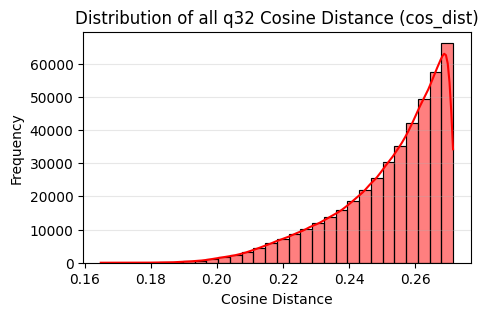

In [8]:
#what is the distribution of the distances of all articles? 
plt.figure(figsize=(5, 3))
sns.histplot(df_32['cos_dist'], kde=True, color='red', bins=30)
    
plt.title('Distribution of all q32 Cosine Distance (cos_dist)')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
    
plt.show()

597     0.253980
639     0.267044
744     0.262133
1108    0.271431
1488    0.215143
Name: cos_dist, dtype: float64


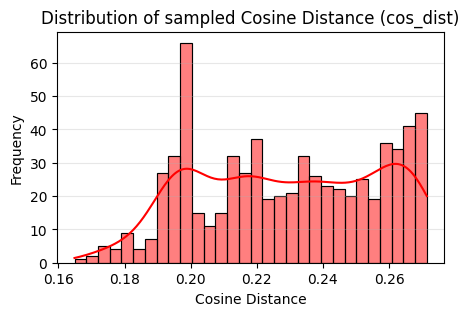

In [9]:
print(df_32_sampled['cos_dist'].head())
#what is the distribution of the distances of sampled articles?
plt.figure(figsize=(5, 3))
sns.histplot(data=df_32_sampled['cos_dist'], kde=True, color='red', bins=30)
    
plt.title('Distribution of sampled Cosine Distance (cos_dist)')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
    
plt.show()

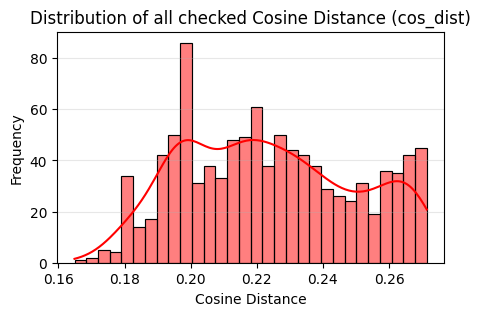

In [10]:
#what is the distribution of the distances of all checked articles?
plt.figure(figsize=(5, 3))
sns.histplot(data=df_32_checked['cos_dist'], kde=True, color='red', bins=30)
    
plt.title('Distribution of all checked Cosine Distance (cos_dist)')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
    
plt.show()

7
[nan '(0.2, 0.22]' '(0.18, 0.2]' '(0.16, 0.18]' '(0.22, 0.24]'
 '(0.24, 0.26]' '(0.26, 0.28]']
   query_32_cosine_bin  woman_murdered  count
0         (0.16, 0.18]            True     20
1          (0.18, 0.2]           False      1
2          (0.18, 0.2]            True    135
3          (0.2, 0.22]           False     10
4          (0.2, 0.22]            True    121
5         (0.22, 0.24]           False     32
6         (0.22, 0.24]            True     98
7         (0.24, 0.26]           False     87
8         (0.24, 0.26]            True     41
9         (0.26, 0.28]           False    114
10        (0.26, 0.28]            True     18


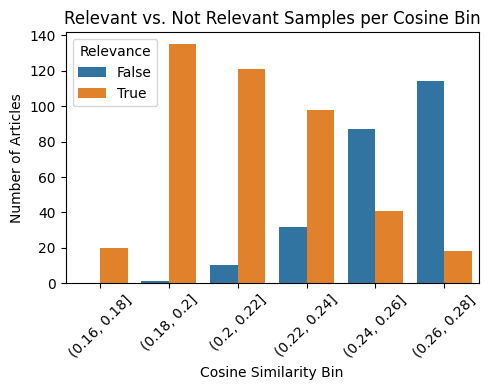

In [11]:
#For the query, how many relavant/irrelavant articles are included in each cosine bin?
#create a list of bins
cos_bin = df_tag['query_32_cosine_bin'].unique()
print(len(cos_bin))
print(cos_bin)

# Count relevant and not relevant per bin
bin_counts = df_sampled.groupby(['query_32_cosine_bin', 'woman_murdered']).size().reset_index(name='count')

print(bin_counts)

# sort bins numerically
bin_order = ['(0.16, 0.18]', '(0.18, 0.2]', '(0.2, 0.22]', '(0.22, 0.24]', '(0.24, 0.26]', '(0.26, 0.28]']
bin_counts['query_32_cosine_bin'] = pd.Categorical(bin_counts['query_32_cosine_bin'], categories=bin_order, ordered=True)
bin_counts = bin_counts.sort_values('query_32_cosine_bin')

# Plotting
plt.figure(figsize=(5,4))
sns.barplot(
    data=bin_counts,
    x='query_32_cosine_bin',
    y='count',
    hue='woman_murdered'
)
plt.title('Relevant vs. Not Relevant Samples per Cosine Bin')
plt.xlabel('Cosine Similarity Bin')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='Relevance')
plt.tight_layout()
plt.show()

In [13]:
 df_32_checked.head()

,id,NUTS,url,hostname,date,cos_dist
597,005a0613-da7a-456d-b40c-c552294bff2f,"DE404, DE408, DE80J",https://www.volksstimme.de/panorama/obduktions...,volksstimme.de,2023-06-28,0.253980
639,00607b72-6c70-4bd2-9a8e-341fc29be756,"DE600, DEF09, DEF0E",https://www.bild.de/regional/hamburg/hamburg-a...,bild.de,2020-05-05,0.267044
744,00748561-ec63-4b22-bd89-78be9a6aa66b,"DE212, DE214, DE21M",http://www.heimatzeitung.de/lokales/landkreis_...,heimatzeitung.de,2017-01-08,0.262133
1108,00acf420-444c-4d22-8434-280894a04f39,DE731,http://www.fnp.de/rhein-main/Gedenken-an-Halit...,fnp.de,2017-04-06,0.271431
1488,00ec12a3-59be-4bfd-9c07-2ae1e38c96ac,DE300,https://www.merkur.de/deutschland/berlin/tote-...,merkur.de,2023-04-18,0.215143


In [34]:
def cos_bin_check(df, df_tag): 
    # Filter to only t/f results
    # Filter out nan for 'woman_murdered' in tagged results
    df_checked_tag = df_tag[df_tag['woman_murdered'].notna()].copy()
    
    # Get list of ids
    checked_ids = df_checked_tag['id']
    
    # Filter dataset to just those ids
    df_query = df[df['id'].isin(checked_ids)].copy()  # Changed from df_query to df
    
    # Sort all checked into bins (add cosine bin row)
    df_query['all_cosine_bin'] = pd.cut(
        df_query['cos_dist'],
        bins=[0.16, 0.18, 0.20, 0.22, 0.24, 0.26, 0.28, np.inf],
        labels=['(0.16, 0.18]', '(0.18, 0.2]', '(0.2, 0.22]', 
                '(0.22, 0.24]', '(0.24, 0.26]', '(0.26, 0.28]', '(0.28+)']
    )
    
    # Merge the bin information back to df_checked_tag
    df_checked_tag = df_checked_tag.merge(
        df_query[['id', 'all_cosine_bin']], 
        on='id', 
        how='left'
    )
    
    # Check result
    print(df_checked_tag['all_cosine_bin'].value_counts())
    
    # Count relevant and not relevant per bin
    bin_counts = df_checked_tag.groupby(['all_cosine_bin', 'woman_murdered'], observed=True).size().reset_index(name='count')
    
    print(bin_counts)
    
    # Sort bins numerically
    bin_order = ['(0.16, 0.18]', '(0.18, 0.2]', '(0.2, 0.22]', '(0.22, 0.24]', '(0.24, 0.26]', '(0.26, 0.28]', '(0.28+)']
    bin_counts['all_cosine_bin'] = pd.Categorical(bin_counts['all_cosine_bin'], categories=bin_order, ordered=True)
    bin_counts = bin_counts.sort_values('all_cosine_bin')
    
    # Plotting
    plt.figure(figsize=(6,4))
    sns.barplot(
        data=bin_counts,
        x='all_cosine_bin',
        y='count',
        hue='woman_murdered'
    )
    plt.title('Relevant vs. Not Relevant Samples per Cosine Bin')
    plt.xlabel('Cosine Similarity Bin')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45)
    plt.legend(title='Relevance')
    plt.tight_layout()
    plt.show()

all_cosine_bin
(0.2, 0.22]     248
(0.22, 0.24]    234
(0.18, 0.2]     231
(0.24, 0.26]    144
(0.26, 0.28]    134
(0.16, 0.18]     20
(0.28+)           0
Name: count, dtype: int64
   all_cosine_bin  woman_murdered  count
0    (0.16, 0.18]            True     20
1     (0.18, 0.2]           False      7
2     (0.18, 0.2]            True    224
3     (0.2, 0.22]           False     46
4     (0.2, 0.22]            True    202
5    (0.22, 0.24]           False    103
6    (0.22, 0.24]            True    131
7    (0.24, 0.26]           False     92
8    (0.24, 0.26]            True     52
9    (0.26, 0.28]           False    115
10   (0.26, 0.28]            True     19


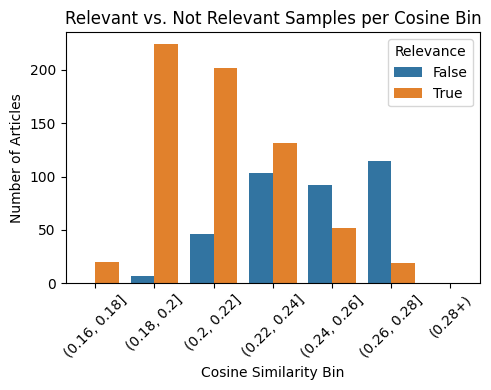

In [28]:
cos_bin_check(dfs_processed['32_homicide-female_DE'],df_tag)

all_cosine_bin
(0.18, 0.2]     136
(0.26, 0.28]    132
(0.2, 0.22]     131
(0.22, 0.24]    130
(0.24, 0.26]    128
(0.16, 0.18]     20
(0.28+)           0
Name: count, dtype: int64
   all_cosine_bin  woman_murdered  count
0    (0.16, 0.18]            True     20
1     (0.18, 0.2]           False      1
2     (0.18, 0.2]            True    135
3     (0.2, 0.22]           False     10
4     (0.2, 0.22]            True    121
5    (0.22, 0.24]           False     32
6    (0.22, 0.24]            True     98
7    (0.24, 0.26]           False     87
8    (0.24, 0.26]            True     41
9    (0.26, 0.28]           False    114
10   (0.26, 0.28]            True     18


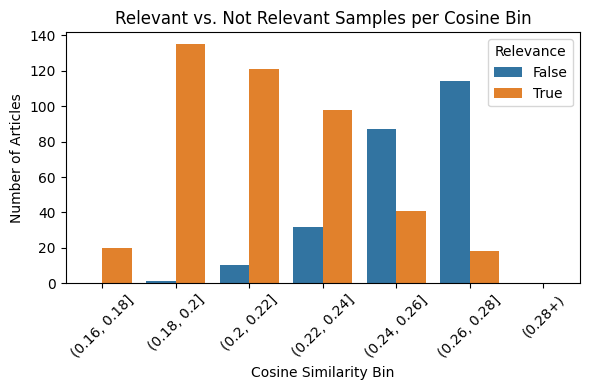

In [35]:
cos_bin_check(df_32_sampled,df_tag)